# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem


In [11]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA


In [12]:
# Configuration

config = {
    'path1': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_1_10.pth",
    'modelname1': 'VAE1',
    'path2': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_4_10.pth",
    'modelname2': 'VAE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
$$ min_ a \sum_{i=1} \sum_{j =1} (A_{(j)} x^i - y^i_j)^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE

In [13]:
# get working directory
import os
# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from VAE.model_def import VAE
DEVICE = torch.device('mps')

# Initialize the models
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)

# Load pretrained weights for model1
model.load_state_dict(torch.load(config['path1']))

# Initialize the model 2
model2 = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)
# Load pretrained weights for model2
model2.load_state_dict(torch.load(config['path2']))




<All keys matched successfully>

## Sampling 
We sample images from the train set and encode those for each model 

In [14]:
# Simple Sampler which takes random points from the train set

def sampler(m,model1, model2): 
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
     # Sample indices from the train set
    indices = np.random.choice(all_images.shape[0], m, replace=False)

    all_images_sample = all_images[indices]
    all_labels_sample = all_labels[indices]
    

    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()  

    return z1, z2, all_images_sample, all_labels_sample

z1, z2, images, labels = sampler(100, model, model2)


# Samples from every class
def sampler_sufficient(m,model1,model2):
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Distinct labels
    labels = torch.unique(all_labels)
    # Sample size per label
    m_per_label = m // len(labels)
    # Sample from each label
    indices = []
    for label in labels:
        indices_label = np.where(all_labels == label)[0]
        indices_label = np.random.choice(indices_label, m_per_label, replace=False)
        indices.extend(indices_label)
    
    all_images_sample = all_images[indices]
    # Get latent space 
    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()

    return z1, z2, all_images_sample

z1_suf, z2_suf, images_suf = sampler_sufficient(100, model, model2)





 

# Calulate optimal matrix 
To ensure invertibility we using as regularization the Matrix in the Frobeniusnorm with lamda as regularization parameter

In [24]:
# Calculates the optimal matrix with abritray regularization (Frobenius normm)
def optimalMatrix(z1,z2,lamda = 0.01):
    # Get the dimensions of the latent space
    d = z1.shape[1]

    # Initalize the matrices
    M = np.zeros((d, d))
    L = np.zeros((d, d))

    # Compute the matrices
    for i in range(d):
        M = M + np.outer(z1[i], z1[i])
        L = L + np.outer(z1[i], z2[i])

    # COmpute the optimal regularized matrix
    A =  L @ np.linalg.inv(M + lamda * np.eye(d)) 

    #A = np.linalg.solve((M + lamda * np.eye(d)).T, L.T).T

    return A

lamda = 1.0

A = optimalMatrix(z1,z2, lamda= lamda )
A_suf = optimalMatrix(z1_suf,z2_suf, lamda)

print(A.shape)
print(A_suf.shape)


print(A_suf)




(32, 32)
(32, 32)
[[-126.66865067  -10.22911651   71.79263189 ...  147.63260211
    16.45132862  292.66076451]
 [-145.95885649  -19.20540068   65.98697425 ...  154.73321862
    22.57631961  331.0244989 ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 ...
 [ -42.29580475    9.82307558   38.17938567 ...   57.10466817
    11.64677671   96.64589354]
 [-159.71470039   -2.39338214   80.37600419 ...  158.19004388
    15.55799903  361.0914047 ]
 [-124.17866293   -1.30139888   77.86221436 ...  149.27807775
    23.18179435  283.5082209 ]]


# Loss calculation 

In [28]:
def loss(A, z1, z2, lamda = 0.01):
    # Compute the loss
    loss = 0
    for i in range(z1.shape[0]):
        loss += np.linalg.norm(z2[i] - A @ z1[i])**2
    return loss + (lamda * np.linalg.norm(A, 'fro')**2)

print(loss(A, z1, z2, lamda= lamda))
print(loss(1 * np.eye(32), z1, z2, lamda= lamda))

31052272.822081447
20704.41312452874


# Distance regarding the sample size 

In [17]:
def transformedDistances(z1, z2, A):
    # Compute the transformed distances
    distances = np.zeros(z1.shape[0])
    for i in range(z1.shape[0]):
        distances[i] = np.linalg.norm(A @ z1[i] - z2[i])

    return distances


distances = transformedDistances(z1, z2, A)
distances_suf = transformedDistances(z1_suf, z2_suf, A_suf)
print(distances.shape)
print(distances_suf.shape)

distances_non = transformedDistances(z1, z2,np.eye(32) )


# Plot the distances
print('Mean Distance:', np.mean(distances))
print('Mean Distance Sufficient:', np.mean(distances_suf))
print('Mean Distance Non:', np.mean(distances_non))



(100,)
(100,)
Mean Distance: 16.474221471331674
Mean Distance Sufficient: 16.316243541432776
Mean Distance Non: 14.34499100872785


# Alignement of Transformed Latent Vectors 

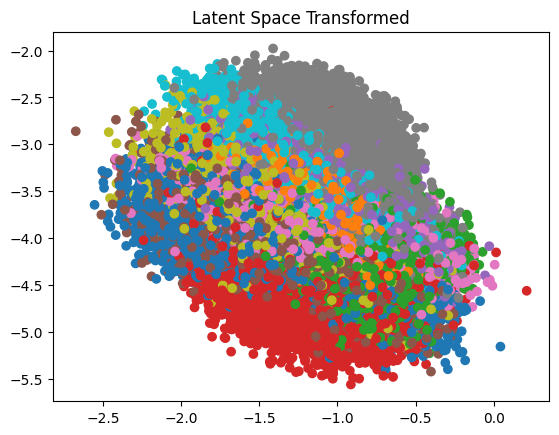

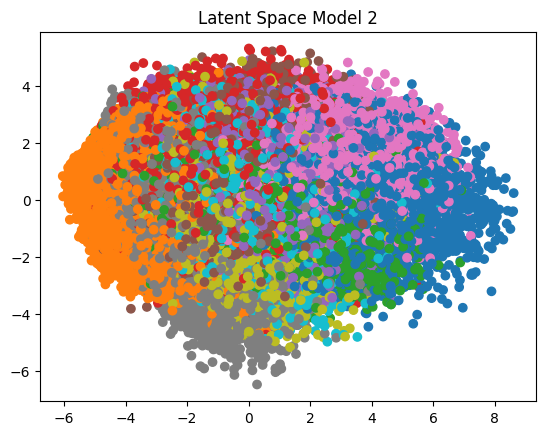

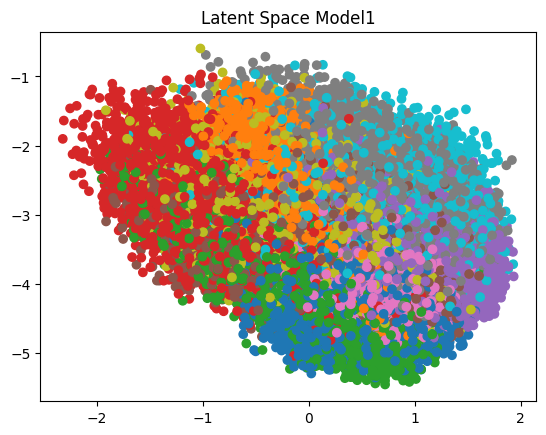

In [18]:
def pca_def(v):
    pca = PCA(n_components=2)
    pca.fit(v)
    return pca


def plotLatentTransformed(model, A, pca1, name):
    images, _ = next(iter(data_loader.train_loader))
    latent_spaces = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        images = images.to(DEVICE)
        images = images.view(images.size(0), -1)
        latent_space = model.getLatenSpace(images)
        latent_space = latent_space.cpu().detach().numpy()
        latent_spaces.append(latent_space)
        all_labels.append(labels.numpy())

    # Concatenate latent space representations from all batches
    latent_space = np.concatenate(latent_spaces, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Transform the latent space
    latent_space_transformed = np.dot(latent_space, A.T)
    # Plot latent space via PCA
    latent_space_pca = pca1.transform(latent_space_transformed)

    # Plot the latent space

 
    plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
    plt.title('Latent Space '+ name)
    plt.show(plot)


    return  plot

I = np.eye(32)

pca1 = pca_def(z2)



plotLatentTransformed(model, A, pca1, 'Transformed')
plotLatentTransformed(model2, I, pca1, 'Model 2')
plotLatentTransformed(model, I, pca1, 'Model1')

# PCA die gleich PCA die unterschiedlich 
# Sample from different classes 
# Ähnliche Werte 




In [19]:
# Latent vector for specific samples 

